In [5]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, multiprocessing as mp
from numpy import random
import torch, cv2, time, random, os, threading, pickle

In [6]:
DTYPE = {
    'boolean': torch.bool, 'ui8': torch.uint8, 'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64, 
    'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64, 'f64Complex': torch.complex64, 'f128Complex': torch.complex128
}
DEVICE = {
    'auto': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), 
    'cpu': torch.device('cpu'), 
    'cuda0': torch.device('cuda:0')
}

DEVICE_CHOICE = 'auto'

In [7]:
def watch(x, area, startPoint):
    rowImg, columnImg, depthImg = x.shape
    rowVision, columnVision = area
    startX, startY = startPoint
    totalCanvas = np.zeros((rowImg+rowVision*2, columnImg+columnVision*2, depthImg), dtype=np.int)
    totalCanvas[rowVision:rowVision+rowImg,columnVision:columnVision+columnImg] = x
    seeing = totalCanvas[startX:startX+rowVision+1, startY:startY+columnVision+1]
    return seeing

In [8]:
def addNoise(x, volumn = 50):
    row, column, depth = x.shape
    noise = np.random.randint(low=-volumn, high=volumn, size=(row, column, depth))
    imgWithNoise = x + noise
    imgWithNoise[imgWithNoise > 255] = 255
    imgWithNoise[imgWithNoise < 0] = 0
    return imgWithNoise

In [9]:
def takePhoto():
    cap = cv2.VideoCapture(0)
    # 初始化摄像头，摄像头适应光源
#     for i in range(20):
#         cap.read()
    ret, frame = cap.read()
    if not ret:
        print('camera not working')
    cap.release()
    print('Image shape: ', frame.shape)
    return frame

In [128]:
class DNN(object):
    def __init__(self, layers=(10, 20, 10), aFunc=('cos', 'PRelu', 'PRelu', 'sin')):
        self.layerNum = len(layers)
        assert self.layerNum >= 1
        torch.manual_seed(0)
        self.layerShapes = layers
        self.aFuncChosen = aFunc
        self.lr = {
            'weight': 0.01,
            'bias': 0.01,
            'relu param': 0.01
        }
        self.inputs = None
        self.targetY = None
        self.weights = [None] * self.layerNum
        self.biases = [None] * self.layerNum
        self.reluParam = [None] * self.layerNum
        self.layers = {
            'Z': [None] * self.layerNum, 
            'N': [None] * self.layerNum, 
            'A': [None] * self.layerNum
        }
        self.BN = {
            'epsilon': 1e-5, 
            'gamma': [1] * self.layerNum, 
            'beta': [0] * self.layerNum
        }
        self.activFunc = {
            'PRelu': lambda x, i: torch.max(x, x * self.reluParam[i]), 
            'sigmoid': lambda x: 1/(1+torch.exp(-x)), 
            'softmax': lambda x: torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x))), 
            'tanh': lambda x: torch.tanh(x), 
            'sin': lambda x: torch.sin(x), 
            'cos': lambda x: torch.cos(x), 
            'linear': lambda x: x
        }
        self.activFuncDer = {
            'PRelu': self._PReluDer,  
            'sigmoid': lambda x: self.activFunc['sigmoid'](x) * (1 - self.activFunc['sigmoid'](x)), 
            'softmax': lambda x, a: self.activFunc['softmax'](x) * (a - self.activFunc['softmax'](x)), 
            'tanh': lambda x: 1 - torch.tanh(x) ** 2, 
            'sin': lambda x: torch.cos(x), 
            'cos': lambda x: -torch.sin(x), 
            'linear': lambda x: 1
        }
        self.lossFunc = {
            'mse': lambda predictY, targetY: (targetY - predictY) ** 2, 
            'bce': lambda predictY, targetY: targetY * torch.log(predictY) + (1 - targetY) * torch.log(1 - predictY)
        }
        self.lossFuncDer = {
            'mse': lambda predictY, targetY: 2 * (targetY - predictY), 
            'bce': lambda predictY, targetY: Y / predictY + (targetY - 1) / (1 - predictY)
        }
    
    def _dA_dReluP(self, x, i):
        data = x.clone()
        data[data > 0] = 0
        data[data <= 0] = torch.mean(data[data <= 0])
        return data
    
    def _PReluDer(self, x, i): 
        data = x.clone()
        data[data > 0] = 1
        data[data <= 0] = self.reluParam[i]
        return data
    
    def batchNorm(self, x, layerIter):
        mean = torch.mean(x)
        variance = torch.mean((x - mean) ** 2)
        # normalize
        xNorm = (x - mean) * 1.0 / torch.sqrt(variance + self.BN['epsilon'])
        return self.BN['gamma'][layerIter] * xNorm + self.BN['beta'][layerIter]
    
    # 生成 w、b, 以x的形状是 m x 1
    def genParam(self, x):
        self.inputs = x
        column = x.shape[0]
        for i, r in enumerate(self.layerShapes):
#             print('row: ', row, '\ncolumn: ', column)
            self.weights[i] = torch.ones(r, column, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.biases[i] = torch.zeros(r, 1, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.reluParam[i] = 0.01
            column = r

    # 前向传播函数
    def forward(self, x):
        inputs = x
#         print('inputs.shape: ', inputs.shape)
    #     layer['non linear'][0] = layer['linear'][0] = inputs
        for i in range(self.layerNum):
#             print(f'w[{i}].shape: ', self.weights[i].shape)
#             print(f'b[{i}].shape: ', self.biases[i].shape)
            inputs = self.batchNorm(inputs, i)
            self.layers['Z'][i] = self.weights[i] @ inputs + self.biases[i]
#             self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
            if self.aFuncChosen[i] == 'PRelu':
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers['Z'][i], i)
            else:
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers['Z'][i])
            inputs = self.layers['A'][i]
#             print(f'layer[{i}].shape: ', self.layers['A'][i].shape)

    # 预测
    def predict(self, x):
        self.forward(x)
        predictY = self.layers['A'][-1]
        print('output: ', predictY.squeeze())
        return predictY
    
    # 反向传播函数
    # input = x, Z = W @ input + b, Y_preditc = activateFunc(Z), L = lossFunc(Y_predict)
    # 根据链式法则 dL / dW = (dL / dY_predict) * (dY_predict / dZ) + (dZ / dW)
    # dL / dY_predict = lossFunc_Der, dY_predict / dZ = activateFunc_Der, dZ/dW = input
    # ==> dL / dW = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * input
    # 同理可证 dL / db = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * 1
    def backprop(self):
        '''
        尚未完成
        '''
        dW = [None] * self.layerNum
        dB = [None] * self.layerNum
        dReluP = [None] * self.layerNum
        dL_Div_dYtrain = self.lossFuncDer['mse'](self.layers['A'][-1], self.targetY)
        dActivation = [None] * self.layerNum
        for i in reversed(range(self.layerNum)):
#             print('i: ', i)
            if self.aFuncChosen[i] == 'PRelu':
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers['Z'][i], i)
            else:
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers['Z'][i])
#             print(f'weight[{i}] shape: {self.weights[i].shape} \nbias[{i}] shape: {self.biases[i].shape} \n')
            if i == self.layerNum - 1:
                dB[i] = dL_Div_dYtrain * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dReluP[i] = torch.mean(dL_Div_dYtrain * self.layers['Z'][i]).item()
            else:
                dB[i] = (torch.transpose(self.weights[i+1], 0, 1) @ dB[i+1]) * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dReluP[i] = torch.mean(torch.transpose(self.weights[i], 0, 1) @ dB[i] * self.layers['Z'][i-1]).item()
#             print(f'dReluP[{i}]: {dReluP[i]}')
            self.weights[i] += dW[i] * self.lr['weight']
            self.biases[i] += dB[i] * self.lr['bias']
            if self.aFuncChosen[i] == 'PRelu':
                self.reluParam[i] += dReluP[i] * self.lr['relu param']
#             print(self.reluParam)
            
    def train(self, inputs, targetY, nanInvestigate=40, epoch = 1000):
        self.targetY = targetY
        for e in range(epoch):
            self.forward(self.inputs)
            if epoch % 100 == 0 and epoch != 0:
                loss = torch.norm(self.layers['A'][-1] - self.targetY)
                print(e, f': loss = {loss}')
                if loss < 5.0:
                    for k,v in self.lr.items():
                        self.lr[k] = 0.0005
                if loss < 2.0:
                    for k,v in self.lr.items():
                        self.lr[k] = 0.0001
                if loss < 1.0 or torch.isnan(loss):
                    return
#                 print(f'{i} Loss: ', torch.mean(self.lossFunc['mse'](self.layers['A'][-1], self.targetY)).item())
#                 print(epoch/100, ': \n', torch.transpose(self.layers['A'][-1], 0, 1))
            self.backprop()
            if e > nanInvestigate and nanInvestigate > 0:
                self.saveParams('d:\\nanInvest_'+str(e)+'.pt', True)
                
    def printShape(self):
        for i in range(self.layerNum):
            print(f'weight[{i}] shape: ', self.weights[i].shape)
            print(f'bias[{i}] shape: ', self.biases[i].shape)
            print(f'Relu Params[{i}]: ', self.reluParam[i])
#             print(f'Z layer shape: ', self.layers['Z'][i].shape)
#             print(f'N layer shape: ', self.layers['N'][i].shape)
#             print(f'A layer shape: ', self.layers['A'][i].shape)
    
    def saveParams(self, PATH, layers=False):
        params = {
            'reluParam': self.reluParam, 
            'weight': self.weights, 
            'bias': self.biases, 
            'BN':self.BN
        }
        if layers:
            params['layers'] = self.layers
        torch.save(params, PATH)
        
    def readParams(self, PATH, layers=False):
        params = torch.load(PATH)
        self.reluParam = params['reluParam']
        self.weights = params['weight']
        self.biases = params['bias']
        self.BN = params['BN']
        if layers:
            self.layers = params['layers']

weight[0] shape:  torch.Size([10, 400])
bias[0] shape:  torch.Size([10, 1])
Relu Params[0]:  0.01
weight[1] shape:  torch.Size([10, 10])
bias[1] shape:  torch.Size([10, 1])
Relu Params[1]:  0.01
weight[2] shape:  torch.Size([400, 10])
bias[2] shape:  torch.Size([400, 1])
Relu Params[2]:  0.01
0 : loss = 19.999989731589288
1 : loss = 19.99879034267986
2 : loss = 19.847077759894596
3 : loss = 19.699216003030802
4 : loss = 19.556094039422604
5 : loss = 19.41761987962163
6 : loss = 19.283679841003167
7 : loss = 19.154149481238804
8 : loss = 19.028907532971033
9 : loss = 18.907828242010755
10 : loss = 18.790793091210553
11 : loss = 18.67768366851004
12 : loss = 18.568383899027225
13 : loss = 18.462779296985047
14 : loss = 18.3607574693035
15 : loss = 18.26220811391937
16 : loss = 18.16702285172393
17 : loss = 18.075095753786904
18 : loss = 17.98632257933954
19 : loss = 17.90060165671102
20 : loss = 17.817833170770093
21 : loss = 17.737919402113814
22 : loss = 17.660764723139824
23 : loss = 

268 : loss = 4.69725610444005
269 : loss = 4.692017351481118
270 : loss = 4.686781964261985
271 : loss = 4.681549946105055
272 : loss = 4.676321300320062
273 : loss = 4.671096030204063
274 : loss = 4.665874139041443
275 : loss = 4.660655630103916
276 : loss = 4.655440506650529
277 : loss = 4.650228771927656
278 : loss = 4.645020429169007
279 : loss = 4.639815481595623
280 : loss = 4.634613932415886
281 : loss = 4.629415784825509
282 : loss = 4.62422104200755
283 : loss = 4.619029707132403
284 : loss = 4.613841783357808
285 : loss = 4.608657273828851
286 : loss = 4.603476181677961
287 : loss = 4.598298510024922
288 : loss = 4.593124261976863
289 : loss = 4.58795344062827
290 : loss = 4.582786049060987
291 : loss = 4.577622090344214
292 : loss = 4.5724615675345115
293 : loss = 4.567304483675808
294 : loss = 4.562150841799397
295 : loss = 4.55700064492394
296 : loss = 4.551853896055474
297 : loss = 4.546710598187407
298 : loss = 4.5415707543005315
299 : loss = 4.536434367363018
300 : loss

539 : loss = 3.4088562681514847
540 : loss = 3.4046107470825926
541 : loss = 3.400369048629551
542 : loss = 3.3961311729598878
543 : loss = 3.3918971202312607
544 : loss = 3.387666890591476
545 : loss = 3.383440484178505
546 : loss = 3.3792179011205015
547 : loss = 3.374999141535818
548 : loss = 3.370784205533027
549 : loss = 3.366573093210932
550 : loss = 3.362365804658588
551 : loss = 3.3581623399553178
552 : loss = 3.353962699170731
553 : loss = 3.349766882364738
554 : loss = 3.3455748895875717
555 : loss = 3.341386720879801
556 : loss = 3.3372023762723497
557 : loss = 3.3330218557865137
558 : loss = 3.328845159433978
559 : loss = 3.324672287216835
560 : loss = 3.320503239127601
561 : loss = 3.316338015149233
562 : loss = 3.312176615255151
563 : loss = 3.308019039409246
564 : loss = 3.3038652875659085
565 : loss = 3.29971535967004
566 : loss = 3.2955692556570684
567 : loss = 3.291426975452972
568 : loss = 3.2872885189742918
569 : loss = 3.283153886128151
570 : loss = 3.2790230768122

807 : loss = 2.406478108964916
808 : loss = 2.403235519867354
809 : loss = 2.399996502740608
810 : loss = 2.396761055761803
811 : loss = 2.3935291771031224
812 : loss = 2.3903008649318327
813 : loss = 2.3870761174102935
814 : loss = 2.383854932695982
815 : loss = 2.3806373089415027
816 : loss = 2.377423244294612
817 : loss = 2.3742127368982335
818 : loss = 2.371005784890478
819 : loss = 2.3678023864046547
820 : loss = 2.3646025395692942
821 : loss = 2.361406242508165
822 : loss = 2.358213493340293
823 : loss = 2.355024290179974
824 : loss = 2.3518386311367965
825 : loss = 2.348656514315655
826 : loss = 2.3454779378167725
827 : loss = 2.3423028997357136
828 : loss = 2.3391313981634028
829 : loss = 2.3359634311861455
830 : loss = 2.3327989968856384
831 : loss = 2.3296380933389953
832 : loss = 2.326480718618758
833 : loss = 2.3233268707929176
834 : loss = 2.32017654792493
835 : loss = 2.317029748073733
836 : loss = 2.3138864692937635
837 : loss = 2.3107467096349796
838 : loss = 2.30761046

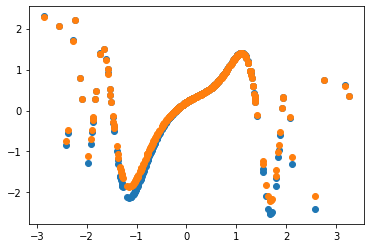

weight[0] shape:  torch.Size([10, 400])
bias[0] shape:  torch.Size([10, 1])
Relu Params[0]:  0.004816332705627686
weight[1] shape:  torch.Size([10, 10])
bias[1] shape:  torch.Size([10, 1])
Relu Params[1]:  0.01
weight[2] shape:  torch.Size([400, 10])
bias[2] shape:  torch.Size([400, 1])
Relu Params[2]:  0.8479886406695659


In [129]:
if __name__ == '__main__':
    layers = (10, 10, 400)
    aFuncs = ('PRelu', 'cos', 'PRelu')
    batchSize = 10
    nn1 = DNN(layers, aFuncs)
    # 所有input全部变型成 m x 1 的形状
    testInput = torch.randn((20, 20), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
    testInput = testInput.view(-1, 1)
    targetY = nn1.batchNorm(5*torch.sin(testInput**3) + 2*torch.cos(2*testInput-1) - torch.tanh(testInput), 0)
    # 生成权重和偏移
    nn1.genParam(testInput)
    nn1.printShape()
    # 训练
    nn1.train(testInput, targetY, nanInvestigate=0, epoch=1000)
    # 预测
    estimateY = nn1.predict(testInput)
    
    plt.scatter(testInput.cpu().numpy().flatten(), targetY.cpu().numpy().flatten())
    plt.scatter(testInput.cpu().numpy().flatten(), estimateY.cpu().numpy().flatten())
    plt.show()
    nn1.printShape()

In [103]:
nn1.layers['A']

[tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]], device='cuda:0', dtype=torch.float64),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]], device='cuda:0', dtype=torch.float64),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
        

In [112]:
nn2 = DNN(layers, aFuncs)
nn2.readParams('d:\\nanInvest_41.pt')
print(nn2.biases)

[tensor([[-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275]], device='cuda:0', dtype=torch.float64), tensor([[5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672]], device='cuda:0', dtype=torch.float64), tensor([[-1.2032e-02],
        [-3.6203e-04],
        [ 1.3286e-01],
        [ 8.2065e-01],
        [ 3.5820e-01],
        [ 4.0628e-01],
        [-1.7814e-03],
        [ 9.0331e-01],
        [-8.3471e-03],
        [-2.0779e-02],
        [ 4.1217e-01],
        [ 7.1294e-01],
        [-1.9788e-02],
        [-2.5701e-04],
        [ 8.4488e-01],
        [ 3.0465e-01],
        [-7.4479e-02],
        [ 3.3996e-03],
        [-2.8695e-02],
        [-6.4443e-02],
        [ 5.4960e-01],
        [-1.3078